#TODO:
# on all genes rather than HVGs
# include enhancers:
Note that in the tutorials, the guidance graph was constructed using only genomic overlap (see [Stage 1](preprocessing.ipynb#Graph-construction)), so the inferred regulatory connections are limited to the proximal promoter and gene body regions.

In real-world analyses, it would be beneficial to extend the genomic range (e.g., 150kb around TSS with distance-decaying weight) or incorporate additional information like Hi-C and eQTL (see our [case study](https://github.com/gao-lab/GLUE/tree/master/experiments/RegInf/s01_preprocessing.py) for an example).

# Imports

In [1]:
import anndata as ad
import networkx as nx
import scanpy as sc
import scglue
from matplotlib import rcParams
import pandas as pd
import numpy as np
work_dir = '../../../output/'
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

from itertools import chain

import anndata as ad
import itertools
import networkx as nx
import pandas as pd
import scanpy as sc
import scglue
import seaborn as sns


/root/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocess

## RNA

In [5]:
rna = ad.read_h5ad(f"{work_dir}/scRNA/adata_rna.h5ad")
rna.var = pd.DataFrame(index=rna.var.index)
rna.obs = rna.obs[['cell_type']]
del rna.obsm 
del rna.obsp 
del rna.uns
rna

AnnData object with n_obs × n_vars = 25547 × 22778
    obs: 'cell_type'
    varm: 'PCs'
    layers: 'counts', 'x_norm'

In [6]:
sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

/root/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


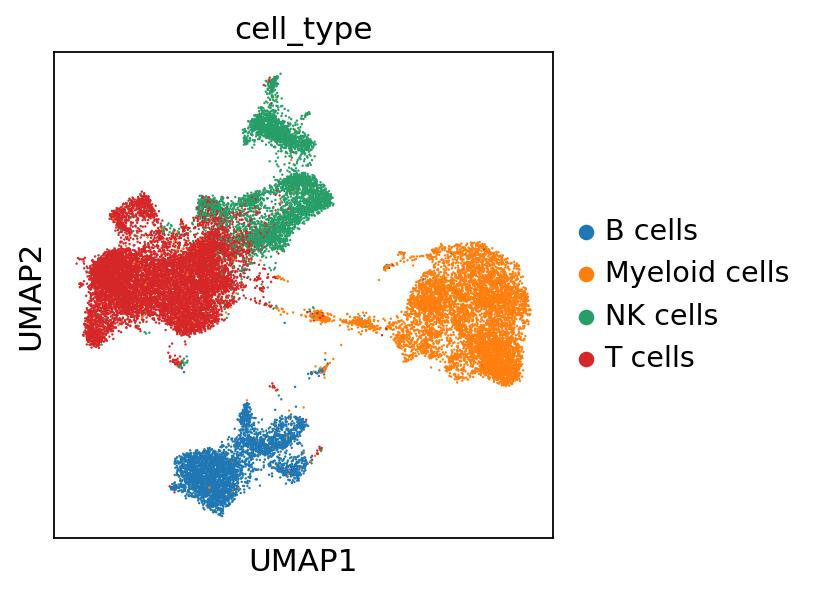

In [7]:
sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.pl.umap(rna, color="cell_type")

In [8]:
scglue.data.get_gene_annotation(
    rna, gtf=ad.read_h5ad(f"{work_dir}/scRNA/adata_rna.h5ad")
    gtf_by="gene_name"
)
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

,chrom,chromStart,chromEnd
location,,,
A1BG,chr19,58345177.0,58353492.0
A1BG-AS1,chr19,58347717.0,58355455.0
A2M,chr12,9067663.0,9116229.0
A2M-AS1,chr12,9065162.0,9068689.0
A2ML1,chr12,8822620.0,8887001.0


In [9]:
# filter those genes without annotation
mask_no_annotation = rna.var.chrom.isna()
rna = rna[:, ~mask_no_annotation]
rna

View of AnnData object with n_obs × n_vars = 25547 × 17069
    obs: 'cell_type'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'tag', 'hgnc_id', 'havana_gene', 'artif_dupl'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'x_norm'
    obsp: 'distances', 'connectivities'

In [10]:
column_names = [
    "chrom",
    "gene_type",
    "gene_id",
    "hgnc_id",
    "havana_gene",
    "tag",
    "score",
    "strand",
    "thickStart",
    "thickEnd",
    "itemRgb",
    "blockCount",
    "blockSizes",
    "blockStarts",
    "artif_dupl",
    "highly_variable_rank"
]

In [11]:
# to avoid astype error in saving 
rna.var[column_names] = rna.var[column_names].astype(str)

/tmp/ipykernel_325441/3613068186.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  rna.var[column_names] = rna.var[column_names].astype(str)


In [15]:
# rna.var = rna.var.astype(str)
rna.write(f'{work_dir}/infer/scglue/rna.h5ad')

## ATAC

In [16]:
atac = ad.read_h5ad(f"{work_dir}/scATAC/adata_atac.h5ad")
atac

/root/anaconda3/envs/scglue/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 25551 × 135358
    obs: 'obs_id', 'cell_type', 'donor_id', 'cell_type_original', 'Donor', 'Cell type'
    var: 'chrom', 'chromStart', 'chromEnd'

In [17]:
scglue.data.lsi(atac, n_components=100, n_iter=15)


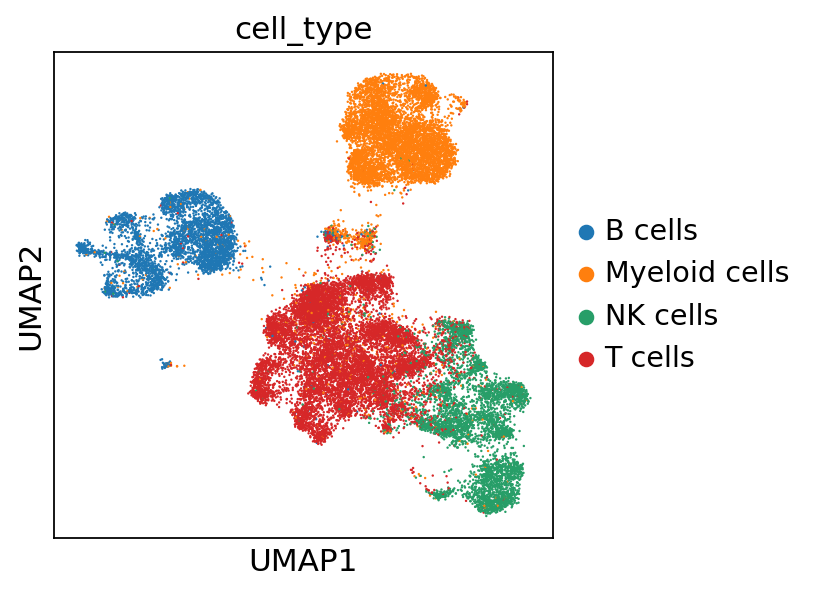

In [18]:
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(atac)
sc.pl.umap(atac, color="cell_type")

In [19]:
atac.write(f'{work_dir}/infer/scglue/atac.h5ad')

# Construct prior regulatory graph

In [2]:
rna = ad.read_h5ad(f'{work_dir}/infer/scglue/rna.h5ad') 
atac = ad.read_h5ad(f'{work_dir}/infer/scglue/atac.h5ad')

In [3]:
guidance = scglue.genomics.rna_anchored_guidance_graph(rna, atac)
guidance

window_graph: 100%|██████████| 17069/17069 [00:01<00:00, 10701.63it/s]


In [4]:
scglue.graph.check_graph(guidance, [rna, atac])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...


[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [23]:
nx.write_graphml(guidance, f"{work_dir}/infer/scglue/guidance.graphml.gz")

# Training

## Configure data


In [5]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=False,
    use_layer="counts", use_rep="X_pca"
)
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=False,
    use_rep="X_lsi"
)

In [6]:
# guidance_hvf = guidance.subgraph(chain(
#     rna.var.query("highly_variable").index,
#     atac.var.query("highly_variable").index
# )).copy()

In [7]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, guidance,
    fit_kws={"directory": f"{work_dir}/infer/scglue/glue"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...


[INFO] autodevice: Using GPU 0 as computation device.


/root/anaconda3/envs/py10/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!
[INFO] SCGLUEModel: Setting `graph_batch_size` = 117724
[INFO] SCGLUEModel: Setting `max_epochs` = 67
[INFO] SCGLUEModel: Setting `patience` = 6
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 3
[INFO] SCGLUETrainer: Using training directory: "../../../output/infer/scglue/glue/pretrain"


/root/anaconda3/envs/py10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/root/anaconda3/envs/py10/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.411, 'g_kl': 0.002, 'g_elbo': 0.413, 'x_rna_nll': 0.291, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.293, 'x_atac_nll': 0.219, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.22, 'dsc_loss': 0.691, 'vae_loss': 0.53, 'gen_loss': 0.495}, val={'g_nll': 0.41, 'g_kl': 0.002, 'g_elbo': 0.412, 'x_rna_nll': 0.289, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.292, 'x_atac_nll': 0.223, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.224, 'dsc_loss': 0.695, 'vae_loss': 0.532, 'gen_loss': 0.497}, 74.1s elapsed
[INFO] LRScheduler: Learning rate reduction: step 1
[INFO] SCGLUETrainer: [Epoch 20] train={'g_nll': 0.395, 'g_kl': 0.002, 'g_elbo': 0.397, 'x_rna_nll': 0.289, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.292, 'x_atac_nll': 0.218, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.219, 'dsc_loss': 0.691, 'vae_loss': 0.526, 'gen_loss': 0.492}, val={'g_nll': 0.395, 'g_kl': 0.002, 'g_elbo': 0.396, 'x_rna_nll': 0.289, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.291, 'x_atac_nll': 0.221, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.22

2024-04-20 11:45:45,715 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "18"...
[INFO] EarlyStopping: Restoring checkpoint "18"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...


/root/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/root/anaconda3/envs/py10/lib/python3.10/site-packages/scglue/data.py:469: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_, resolution=resolution)


[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (24, 28)...
[INFO] estimate_balancing_weight: Estimating balancing weight...


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!
[INFO] SCGLUEModel: Setting `graph_batch_size` = 117724
[INFO] SCGLUEModel: Setting `align_burnin` = 12
[INFO] SCGLUEModel: Setting `max_epochs` = 67
[INFO] SCGLUEModel: Setting `patience` = 6
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 3
[INFO] SCGLUETrainer: Using training directory: "../../../output/infer/scglue/glue/fine-tune"


/root/anaconda3/envs/py10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.375, 'g_kl': 0.002, 'g_elbo': 0.377, 'x_rna_nll': 0.289, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.292, 'x_atac_nll': 0.219, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.219, 'dsc_loss': 0.689, 'vae_loss': 0.526, 'gen_loss': 0.492}, val={'g_nll': 0.374, 'g_kl': 0.002, 'g_elbo': 0.376, 'x_rna_nll': 0.29, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.293, 'x_atac_nll': 0.217, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.217, 'dsc_loss': 0.69, 'vae_loss': 0.525, 'gen_loss': 0.491}, 90.7s elapsed
[INFO] SCGLUETrainer: [Epoch 20] train={'g_nll': 0.37, 'g_kl': 0.002, 'g_elbo': 0.371, 'x_rna_nll': 0.289, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.291, 'x_atac_nll': 0.219, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.219, 'dsc_loss': 0.688, 'vae_loss': 0.525, 'gen_loss': 0.491}, val={'g_nll': 0.369, 'g_kl': 0.002, 'g_elbo': 0.371, 'x_rna_nll': 0.287, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.29, 'x_atac_nll': 0.221, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.221, 'dsc_loss': 0.687, 'vae_loss': 0.526, 'gen_loss'

2024-04-20 12:58:34,701 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "38"...
[INFO] EarlyStopping: Restoring checkpoint "38"...


In [8]:
glue.save(f"{work_dir}/infer/scglue/glue.dill")


In [9]:
dx = scglue.models.integration_consistency(
    glue, {"rna": rna, "atac": atac}, guidance
)
dx

/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


[INFO] metacell_corr: Computing correlation on 10 common metacells...


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


[INFO] get_metacells: Clustering metacells...


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


[INFO] metacell_corr: Computing correlation on 20 common metacells...


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


[INFO] get_metacells: Clustering metacells...


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


[INFO] metacell_corr: Computing correlation on 50 common metacells...


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


[INFO] get_metacells: Clustering metacells...


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


[INFO] metacell_corr: Computing correlation on 100 common metacells...


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


[INFO] get_metacells: Clustering metacells...


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


[INFO] metacell_corr: Computing correlation on 200 common metacells...


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


,n_meta,consistency
0,10,0.307024
1,20,0.285231
2,50,0.248646
3,100,0.220655
4,200,0.190391


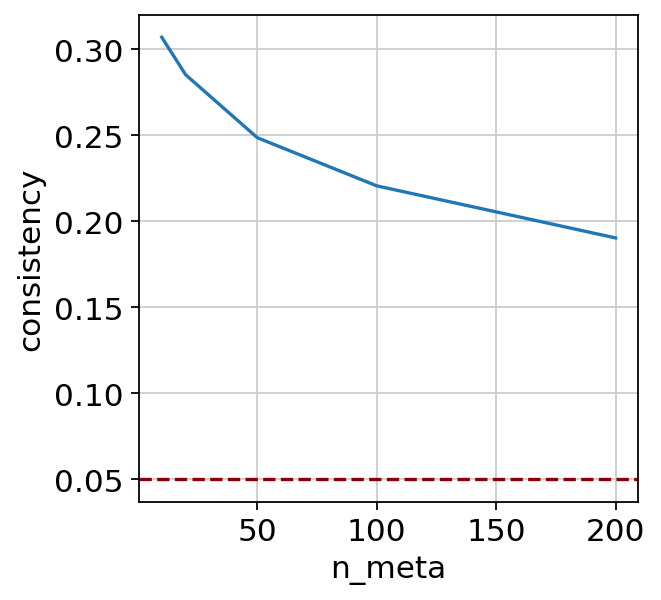

In [10]:
_ = sns.lineplot(x="n_meta", y="consistency", data=dx).axhline(y=0.05, c="darkred", ls="--")

In [11]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

In [12]:
combined = ad.concat([rna, atac])

/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [13]:
combined

AnnData object with n_obs × n_vars = 51098 × 0
    obs: 'cell_type', 'balancing_weight'
    obsm: 'X_umap', 'X_glue'

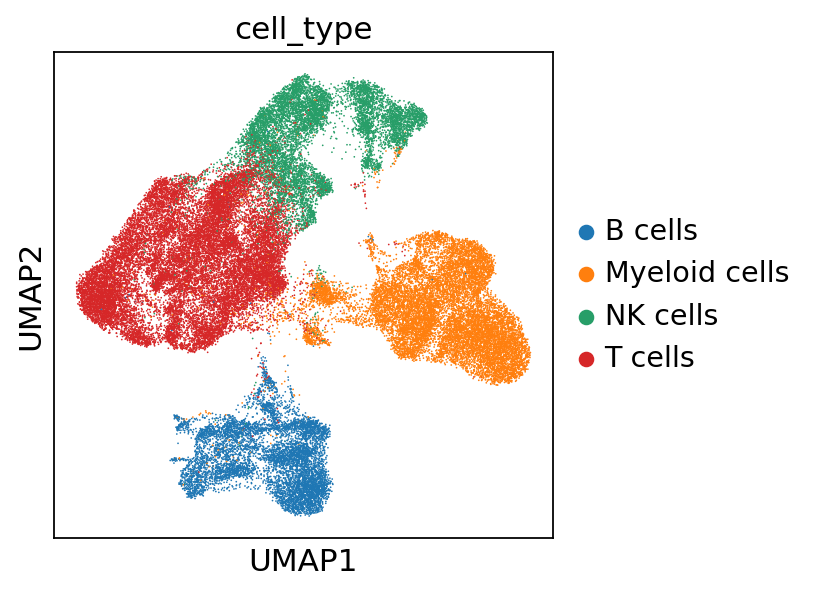

In [14]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)
sc.pl.umap(combined, color=["cell_type"], wspace=0.65)

In [16]:
feature_embeddings = glue.encode_graph(guidance)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

,0,1,2,3,4
A1BG,-0.543390,-0.115343,0.002146,0.197768,-0.000911
A1BG-AS1,-0.717190,0.048924,0.000183,0.209785,-0.000062
A2M,-0.086226,-0.133900,-0.000235,0.100623,0.002331
A2M-AS1,0.196275,0.257461,-0.000521,0.109849,0.002360
A2ML1,0.514409,-0.092996,0.000199,0.177595,0.002930


In [17]:
rna.varm["X_glue"] = feature_embeddings.reindex(rna.var_names).to_numpy()
atac.varm["X_glue"] = feature_embeddings.reindex(atac.var_names).to_numpy()

In [18]:
rna.write(f"{work_dir}/infer/scglue/rna-emb.h5ad", compression="gzip")
atac.write(f"{work_dir}/infer/scglue/atac-emb.h5ad", compression="gzip")
nx.write_graphml(guidance, f"{work_dir}/infer/scglue/guidance.graphml.gz")

In [4]:
# rna = ad.read(f"{work_dir}/infer/scglue/rna-emb.h5ad")
# atac.write(f"{work_dir}/infer/scglue/atac-emb.h5ad", compression="gzip")
nx.write_graphml(guidance, f"{work_dir}/infer/scglue/guidance.graphml.gz")

In [8]:
guidance = nx.read_graphml(f"{work_dir}/infer/scglue/guidance.graphml.gz")

In [17]:
gene2peak = pd.read_csv(f"{work_dir}/infer/scglue/gene2peak.links", sep='\t', header=None)
gene2peak.columns = ['']

,0,1,2,3,4,5,6
0,chr1,778746,778747,chr1,778292,779204,1.000000
1,chr1,825137,825138,chr1,822873,823635,0.872104
2,chr1,825137,825138,chr1,825292,826033,0.790936
3,chr1,825137,825138,chr1,827076,827959,0.669489
4,chr1,825137,825138,chr1,837612,838149,0.912630
...,...,...,...,...,...,...,...
94453,chrY,20575518,20575519,chrY,20558402,20559294,0.925150
94454,chrY,20575518,20575519,chrY,20573112,20573918,0.874066
94455,chrY,20575518,20575519,chrY,20575222,20576136,0.704514
94456,chrY,20575775,20575776,chrY,20573112,20573918,0.912777
